# Load Model Performance Assessment
In this NoteBook the accuracy of the load model for different levels of aggregation is tested. Morever, an extension of the load model including WD/WE is assessed.

In [1]:
import numpy as np
import pandas as pd
from time import time
import pickle as pk
import matplotlib.pyplot as plt
from csss.SolarDisagg import createTempInput
from sklearn.linear_model import LinearRegression
import Custom_Functions.error_functions as ef
from csss.utilities import Setup_load, load_model
from copy import deepcopy

Loading Load and Weather data

In [2]:
Setup_load = Setup_load()
Setup_load.QueryOrLoad()
load_data, load_data_2, weather, grouped_data, ids, solar_ids, homeids = Setup_load.load_setup()
load_data = deepcopy(load_data_2) # In this script I need the data in this format
netload = load_data['netload']
ids = list(netload.columns)
solar_binary = np.asarray([i in solar_ids['solar'] for i in ids]).astype('float') # binary vector solar or not

reading 61047030 values from csv took 8.12 seconds
There are 167 homes with complete data
105 homes solar
62 homes with no solar


Here the daily normalized average aggregate load is plot as a function of the level of aggregation

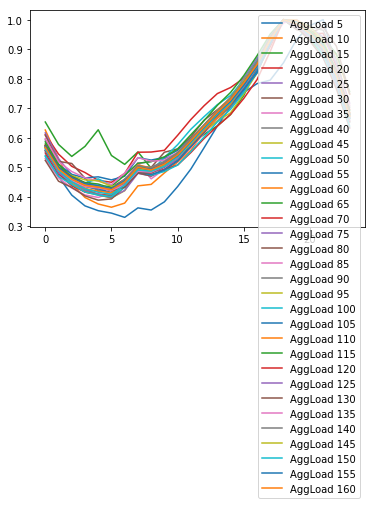

In [3]:
Load_Shape_agg = []
step = 5
N = np.arange(step,160+step,step)
for i in range(len(N)):
    agg_ids = np.random.choice(list(ids),N[i],replace=False)
    df = load_data['use'][agg_ids]
    agg_load = df.sum(axis=1)
    Load_Shape = df.groupby(df.index.hour).mean()
    Load_Shape_agg.append(agg_load.groupby(agg_load.index.hour).mean())

# Plotting Load_Shapes and aggregated Load Shape
fig = plt.figure()
ax = plt.gca()
for i in range(len(Load_Shape_agg)):
    plt.plot(Load_Shape_agg[i]/Load_Shape_agg[i].max(), label = 'AggLoad {}'.format(N[i]))
    plt.legend()
plt.show()

In this section the load model suggested in the BuildSys paper is validated as a function of the level of aggregation. 

In [ ]:
N = np.array([ 1,5,10, 20,30,  50,  70,  100, 130, 160]) # Level of aggregation tested
N_iter = 10 # number of iterations for each level of aggregation
list_all = [] # Preprocessing of the list oh houses in each level of aggregation and iteration
for i in range(N_iter):
    list_temp = []
    first = True
    for j in range(len(N)):
        if first == True:
            list_temp = list(np.random.choice(list(ids),N[j],replace=False))
            first = False
        else:
            if len(list_temp) < 2:
                list_temp.append(list_temp + list(np.random.choice(list(set(ids)-set(list_temp)),N[j] - len(list_temp),replace = False)))
            else:
                previous_ids = list_temp[j-1]
                list_temp.append(previous_ids + list(np.random.choice(list(set(ids)-set(previous_ids)),N[j] - len(previous_ids),replace = False)))
    list_all.append(list_temp)   

MAPE_list = []
N_train = int(4*24*30) # 1 month: 4*24*30 since the data are in 15 min resolution
N_test = N_train
pos = 0 # Control variable if the simulation should not start from the first piece of data avaialble.
step = N_train # In the normal setup th emodel is trained in the 30 days before the 30 days of Test and then predict for the whole 30 days of Test. However step lets you control how often you should retrain the model
for j in range(len(N)):
    i=0 # parameter to control the sliding window
    MAPE = []
    while (pos+step*i+N_train < len(agg_load)) & (pos+step*i+N_train+N_test < len(agg_load)):
        MAPE_iter = np.zeros((N_iter,2))
        MAPE_iter_wd = np.zeros((N_iter,2))
        for k in range(N_iter):
#            agg_ids = np.random.choice(list(ids),N[j],replace=False)
            agg_ids = list_all[k][j]
            df = load_data['use'][agg_ids]
            if N[j] > 1:
                agg_load = df.sum(axis=1)
            else:
                agg_load = df

            # Definition of train and test set            
            train_set = (agg_load.index >= agg_load.index[pos+step*i]) & (agg_load.index < agg_load.index[(pos+step*i+N_train)])
            test_set = (agg_load.index >= agg_load.index[pos+step*i+N_train]) & (agg_load.index < agg_load.index[(pos+step*i+N_train+N_test)])
                        
            # Initialisation
            LSE    = deepcopy(load_model())
            LSE_wd = deepcopy(load_model())
            y = agg_load.values
            
            #Train
            LSE.fit(agg_load[train_set],weather[train_set])
            LSE_wd.fit(agg_load[train_set],weather[train_set], WD_WE = True)
            
#            Train score
            yp_train = LSE.predict(agg_load[train_set],weather[train_set])
            yp_train_wd = LSE_wd.predict(agg_load[train_set],weather[train_set])
            
            #Test score
            yp_test    = LSE.predict(agg_load[test_set],weather[test_set])
            yp_test_wd = LSE_wd.predict(agg_load[test_set],weather[test_set])
            
            #Save Results
            MAPE_iter[k,] =   np.stack((ef.mape(yp_train,y[train_set]),ef.mape(yp_test,y[test_set])))
            MAPE_iter_wd[k,] =   np.stack((ef.mape(yp_train_wd,y[train_set]),ef.mape(yp_test_wd,y[test_set])))

        MAPE.append((N[j],MAPE_iter.mean(axis=0)[0],MAPE_iter.mean(axis=0)[1],MAPE_iter_wd.mean(axis=0)[0],MAPE_iter_wd.mean(axis=0)[1]))
        i+=1
    MAPE = pd.DataFrame(MAPE,columns=['N','train','test','train_wd','test_wd'])
    MAPE_list.append(MAPE)
    print('Percentage completed: ',(j+1)/len(N)*100)

# Save resutls to file
#fp = 'Validation/data/MAPE_load N_train = {} days, N_test = {} days _ 48hWD'.format(int(N_train/96),int(N_test/96))
#with open(fp, 'wb') as f:
#    pk.dump([MAPE_list,N_train,N_test,N], f)

load the simulation results and make some plots

In [10]:
N_train = int(4*24*30) # 1 month: 4*24*30 since the data are in 15 min resolution
N_test = N_train
fp = 'Validation/data/MAPE_load N_train = {} days, N_test = {} days _ 48hWD'.format(int(N_train/96),int(N_test/96))
with open(fp, 'rb') as f:
    [MAPE_list,N_train,N_test,N] = pk.load(f)

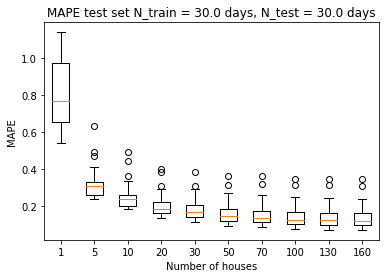

In [24]:
# Plot MAPE Vs Aggregation
plt.boxplot([MAPE_list[i]['test'] for i in range(len(N))],labels=[str(a) for a in N])
plt.title('MAPE test set N_train = {} days, N_test = {} days'.format(N_train/96,N_test/96))
plt.xlabel('Number of houses')
plt.ylabel('MAPE')
plt.show()
# plt.savefig('Validation/figures/MAPE test set N_train = {} days, N_test = {} days _ 48hWD_agg_by_house'.format(int(N_train/96),int(N_test/96)))

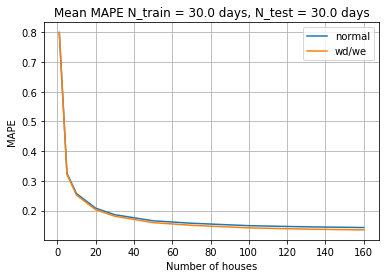

In [25]:
# Plot the trend for weekday and weekend
MAPE_mean = [MAPE_list[i]['test'][MAPE_list[i]['test'] < 100].mean() for i in range(len(MAPE_list))]
MAPE_mean_wd = [MAPE_list[i]['test_wd'][MAPE_list[i]['test_wd'] < 100].mean() for i in range(len(MAPE_list))]
plt.plot(N,MAPE_mean)
plt.plot(N,MAPE_mean_wd)
plt.legend(['normal','wd/we'])
plt.title('Mean MAPE N_train = {} days, N_test = {} days'.format(N_train/96,N_test/96))
plt.xlabel('Number of houses')
plt.ylabel('MAPE')
plt.grid(True)
plt.show()
# plt.savefig('Validation/figures/Mean MAPE nowd-wd N_train = {} days, N_test = {} days _ 48hWD_agg_by_house'.format(int(N_train/96),int(N_test/96)))